In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os

# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first

os.chdir('/g/data/xv83/np1383/CAFE60_eqpac/')
from a_carbon_math import carbon_flux
from a_model_cutting_functions import CAFE60_eqpac_cutter, cut_regrid_reynolds_sst,cut_process_sst_obs_trends,proc_landschutzer,process_co2_land_trends

In [4]:
# Set up the Local Dask Cluster
# from dask.distributed import Client, LocalCluster,Scheduler
# from dask_jobqueue import SLURMCluster
# cluster = LocalCluster()
# client = Client(cluster)
# print(client)

In [2]:
# Set up the remote dask cluster
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,memory="8GB")
client = Client(cluster)
#cluster.scale(cores=4)
cluster.adapt(minimum=2, maximum=6)

In [11]:
# Check the Cluster
client

Client Scheduler: tcp://10.0.128.142:38315 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 4 Memory: 14.92 GiB


In [6]:
!squeue -u np1383

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
              6769      main dask-wor   np1383  R       0:46      1 ood-n4
              6768       vdi sys/dash   np1383  R       2:44      1 ood-vn14


In [ ]:
# Check the model data works first

# modeldata_bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip',consolidated=True)
# modeldata_ocean=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip',consolidated=True)
# modeldata_atmos=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/atmos_isobaric_month.zarr.zip',consolidated=True)

Starting on Variable: sst
Begin Dataset Size: 29.85984 GB
renamed lons
Saving Mean Ens Dataset Size: 0.03038784 GB


/g/data4/xv83/np1383/CAFE60_eqpac/a_model_cutting_functions.py:258: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  modeldata['time']=np.array(modeldata.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


Saved to: /g/data/xv83/np1383/CAFE_data/processed/eqpac/sst_ensmean_1982.nc
Saved to: /g/data/xv83/np1383/CAFE_data/processed/eqpac/sst_ensstd_1982.nc


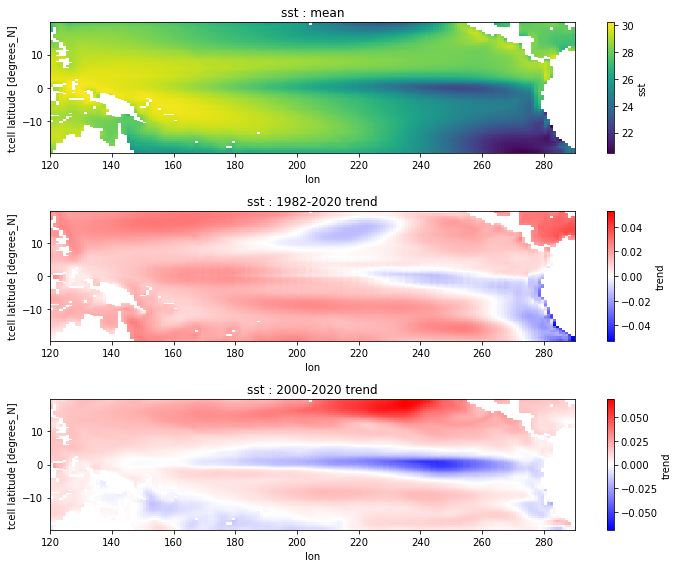

In [12]:
#Process CAFE SST for equatorial Pacific
CAFE60_eqpac_cutter(modelType='physics',
                        variable='sst',
                        cut_eqpac=True,
                        save_all_data=False,
                        trend=True,
                        force=True)

In [ ]:
CAFE60_eqpac_cutter(modelType='BGC',
                        variable='stf10',
                        cut_eqpac=False,
                        save_all_data=False,
                        trend=True,
                        plot=False,
                        force=True)

In [ ]:
CAFE60_eqpac_cutter(modelType='BGC',
                        variable=['stf10','pprod_gross_2d','export_prod','surface_zoo','surface_dic'],
                        cut_eqpac=True,
                        save_all_data=False,
                        trend=True,
                        plot=False,
                        force=True)

Starting on Variable: u_ref
Begin Dataset Size: 3.5831808 GB
vars probably already named
Mean Ens Dataset already exists: /g/data/xv83/np1383/CAFE_data/processed/eqpac/u_ref_ensmean_1982.nc


/g/data4/xv83/np1383/CAFE60_eqpac/a_model_cutting_functions.py:258: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  modeldata['time']=np.array(modeldata.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


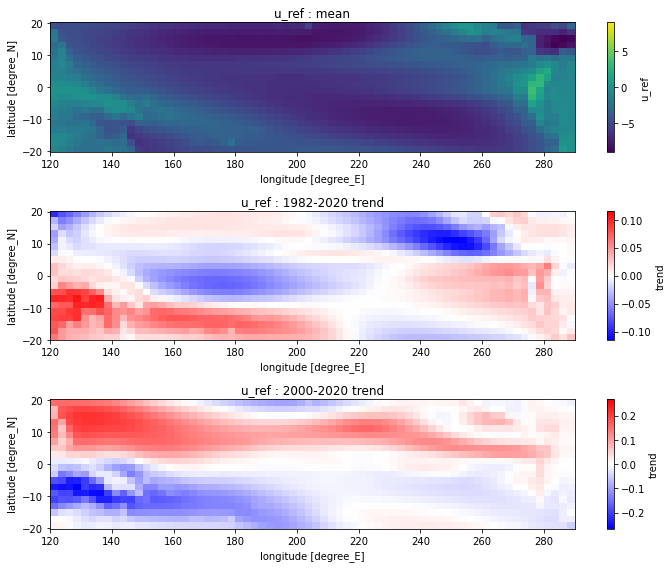

Starting on Variable: v_ref
Begin Dataset Size: 3.5831808 GB
vars probably already named
Saving Mean Ens Dataset Size: 0.00248064 GB


/g/data4/xv83/np1383/CAFE60_eqpac/a_model_cutting_functions.py:258: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  modeldata['time']=np.array(modeldata.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


Saved to: /g/data/xv83/np1383/CAFE_data/processed/eqpac/v_ref_ensmean_1982.nc
Saved to: /g/data/xv83/np1383/CAFE_data/processed/eqpac/v_ref_ensstd_1982.nc


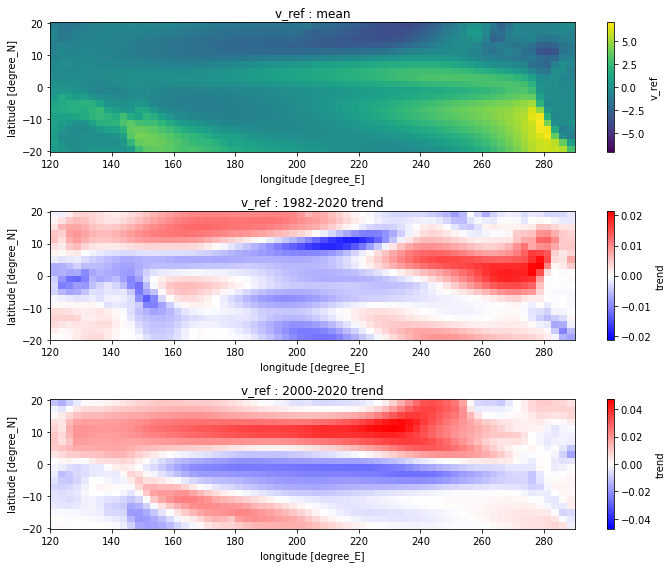

In [7]:
CAFE60_eqpac_cutter(modelType='atmos',
                        variable=['u_ref','v_ref'],
                        cut_eqpac=True,
                        save_all_data=False,
                        trend=True,
                        fix_long_coords=False,
                        plot=True,
                        force=False)

In [9]:
# Ok and Calculate and save the windspeed
u=xr.open_dataset('/g/data/xv83/np1383/CAFE_data/processed/eqpac/u_ref_ensmean_1982.nc')
v=xr.open_dataset('/g/data/xv83/np1383/CAFE_data/processed/eqpac/v_ref_ensmean_1982.nc')
ws=np.sqrt((u.u_ref**2)+(v.v_ref**2))
ws.to_netcdf('/g/data/xv83/np1383/CAFE_data/processed/eqpac/ws_ensmean_1982.nc')

In [ ]:
#Cut PhyDownload_TPCA()

#Ok is defunct. But need to update the core function in Process Data to allow for isel(st_ocean=d)
def cut_phyto():
    bgc_month= xr.open_zarr('/OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/ocean_bgc_month.zarr',consolidated=True)
    bgc_month['xt_ocean']=bgc_month['xt_ocean']+360
    phy=bgc_month.phy.sel(xt_ocean=slice(120,290),yt_ocean=slice(-20,20)).isel(st_ocean=1)
    phy['time']=np.array(phy.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
    phy.to_netcdf('/scratch1/pit071/CAFE60/phy_15m.nc')